<a href="https://colab.research.google.com/github/xcharita/API/blob/master/Milestone_Report_II_DJIA_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone II DJIA and Reuters articles
# Milestone Report II
Charita Ramnathsing July 2020

#Learning Objective
Integrate and apply the technical competency learned from the 3 technical units 

Utilize the work you have completed using Machine learning and the more advanced ML/specialization specific techniques to complete your report.

Detect and justify utilized machine learning techniques (if applicable to the project), including feature selection and evaluation metric/technique.



In [ ]:
# basic modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# plotting interactive charts
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, output_file, show
from bokeh.transform import factor_cmap
from bokeh.io import output_notebook, show

# text helper functions and modules
import nltk
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

# for punctuation
import string
# setting to date formats
from datetime import datetime

# use for text calculation
import statistics 

#import sys

In [ ]:
#read files
DJIA = pd.read_csv(
        "DJI_2018.csv",
        parse_dates=['Date']
    )

In [ ]:
df_text = pd.read_csv('reuters_articles_for_prediction.csv', engine='python', error_bad_lines=False, encoding='utf8', usecols=['date','year', 'month', 'day', 'title', 'publication'])

Skipping line 79330: unexpected end of data


In [ ]:
# filter only the Reuters articles
df_text = df_text[df_text.publication == 'Reuters']

In [ ]:
# drop the columns which are not needed 
df_reuters = df_text.drop(['month', 'day', 'publication'], axis=1)

In [ ]:
# filter articles for only the year '2018'
text_2018 = df_reuters[df_reuters['year'] == 2018].sort_index().drop('year', axis=1).reset_index()

In [ ]:
punc = list(set(string.punctuation))

In [ ]:
porter = PorterStemmer()
lemma = nltk.stem.wordnet.WordNetLemmatizer()

In [ ]:
def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

In [ ]:
def process_text(text):
    text = text.replace("U.S.", "usa")
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+-', '', each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in ENGLISH_STOP_WORDS]
    text = [each for each in text if len(each) > 1]
    text = [lemma.lemmatize(each) for each in text if not each.isnumeric()]
    return text


In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
vectorizer = TfidfVectorizer(max_df= 0.1, tokenizer = process_text, stop_words = ENGLISH_STOP_WORDS)
tdm = vectorizer.fit_transform(text_2018.title)

In [ ]:
freqs = {word: tdm.getcol(idx).sum() for word, idx in vectorizer.vocabulary_.items()}

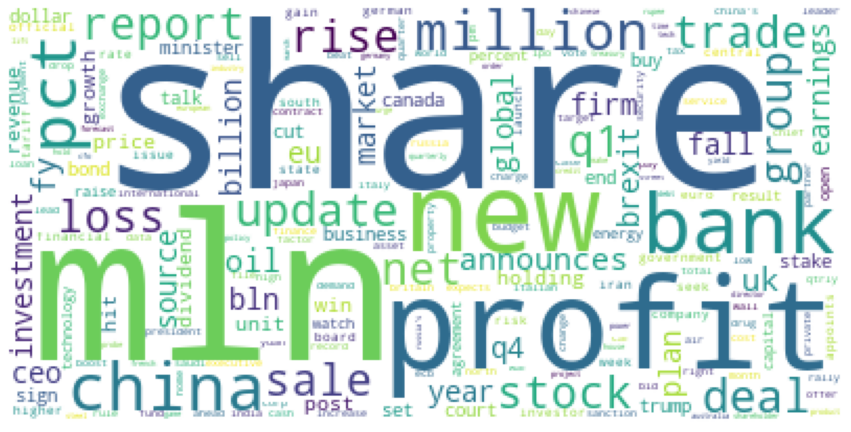

In [ ]:
w = WordCloud(mode='RGBA',background_color='white').generate_from_frequencies(freqs)

plt.figure(figsize=(15,10))
plt.imshow(w)
plt.axis("off") 
plt.show()

# Visualization with Bokeh


In [ ]:
# sort first
text_2018_sorted_by_date = text_2018.sort_values(by='date')

In [ ]:
# make the DataFrame 'datetime' ready
text_2018_sorted_by_date['date'] = pd.to_datetime(text_2018_sorted_by_date.date)

In [ ]:
# and then groupby for going through TextBlob
text_2018_sorted_by_date_blob = (sorted(text_2018_sorted_by_date.groupby(['date'])))

In [ ]:
# since not all polarity and subjectivity can be taken on one day, i have calculated the average
def check_blob(df, txb_pol, txb_sub ):
    pol = []
    sub = []

    for i, t in df.iterrows(): 
        txb = TextBlob(t.title)
        pol.append(txb.polarity)
        sub.append(txb.subjectivity)
    txb_pol = np.mean(pol)
    txb_sub = np.mean(sub)

    return txb_pol, txb_sub

In [ ]:
# Polarity and Subjectivity will be given into a list where each item in the list is an average
pol_per_date = []
sub_per_date = []
pol_blob = []
sub_blob = []
date_col = []

for i, item in text_2018_sorted_by_date_blob:
    
    pol_blob, sub_blob = check_blob(item.set_index('index'), pol_blob, sub_blob)

    pol_per_date.append(pol_blob)
    sub_per_date.append(sub_blob)
    # date is being formatted for better readability and further date-format for the visualization DataFrame 
    date_col.append(datetime.strftime(datetime.date(i), '%Y-%m-%d'))

NameError: ignored

In [ ]:
# make dictionary and convert string Date time into Python Date time object for further plotting
visualization = {'Date': pd.to_datetime(date_col) , 'Polarity': pol_per_date, 'Subjectivity': sub_per_date }

In [ ]:
# Import figure from bokeh.plotting
from bokeh.plotting import figure

source = ColumnDataSource(test)
sentiment = ['Polarity', 'Subjectivity']

# Create the figure: p
p = figure(plot_width=900, plot_height=400,x_axis_type='datetime')

# Plot Polarity and Subjectivity
p.circle(visualization['Date'], visualization['Polarity'], color='blue', size=5, legend_label='Polarity')
p.circle(visualization['Date'], visualization['Subjectivity'], color='green', size=5, legend_label='Subjectivity')

 
show(p)

In [ ]:
#make parameters ready for plotting of the DJIA-index
max_volume = max(DJIA.Volume)
djia_by_date = DJIA.reset_index()
djia_by_date['Volume mln'] = djia_by_date['Volume']/1000000

source = ColumnDataSource(djia_by_date)

TOOLS = "pan, wheel_zoom, box_zoom, box_select,reset, save"

# Graph has date on the x-axis
p = figure(title="Scroll over the graph for 'Open' and 'Close' numbers", x_axis_type='datetime', tools=TOOLS)

p.line(x='Date', y='Volume mln', source=source) #build a line chart

p.yaxis.axis_label = 'Traded Volumes - Dow Jones stocks portfolio (mln)'

p.xgrid.grid_line_color = None

# add a hover tool and show the date in date time format
hover = HoverTool()
hover.tooltips=[
    ('Open', '@Open{0.2f}'),
    ('Close', '@Close{0.2f}')
]

p.add_tools(hover)

output_notebook() # show the output in jupyter notebook


In [ ]:
show(p)

BiDirectional **LSTM** **bold text**

In [ ]:
import numpy
#from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import tensorflow as tf

import pandas as pd
from pandas import read_csv
import io

Using TensorFlow backend.


In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
file = r'reuters_articles_for_prediction.csv' 

In [34]:
file2 = r'DJI_2018.csv'

In [35]:
djia = pd.read_csv(file2)

In [36]:
print(djia)

           Date          Open  ...     Adj Close     Volume
0    2018-01-02  24809.349609  ...  24824.009766  341130000
1    2018-01-03  24850.449219  ...  24922.679688  456790000
2    2018-01-04  24964.859375  ...  25075.130859  403280000
3    2018-01-05  25114.919922  ...  25295.869141  358020000
4    2018-01-08  25308.400391  ...  25283.000000  341390000
..          ...           ...  ...           ...        ...
245  2018-12-21  22871.740234  ...  22445.369141  900510000
246  2018-12-24  22317.279297  ...  21792.199219  308420000
247  2018-12-26  21857.730469  ...  22878.449219  433080000
248  2018-12-27  22629.060547  ...  23138.820313  407940000
249  2018-12-28  23213.609375  ...  23062.400391  336510000

[250 rows x 7 columns]


In [37]:
reuters = pd.read_csv(file , sep=',', encoding='utf-8', engine='python', error_bad_lines=False)

Skipping line 283525: unexpected end of data


In [38]:
reuters[:10]

,Unnamed: 0,Unnamed: 0.1,date,year,month,day,author,title,article,url,section,publication
0,500000,500000,2017-08-16 00:00:00,2017,8.0,16,NaN,BRIEF-Yes Bank cuts savings account interest r...,Aug 16 (Reuters) - Yes Bank Ltd: * Says cuts s...,https://www.reuters.com/article/brief-yes-bank...,Financials,Reuters
1,500001,500001,2018-03-14 00:00:00,2018,3.0,14,NaN,"China, U.S. should take responsibility for ste...","BEIJING, March 14 (Reuters) - China and the Un...",https://www.reuters.com/article/china-economy-...,Chinese Labor Unrest,Reuters
2,500002,500002,2017-08-21 00:00:00,2017,8.0,21,NaN,BRIEF-Blujay solutions raises up to $500 milli...,Aug 21 (Reuters) - Blujay solutions: * Raises ...,https://www.reuters.com/article/brief-blujay-s...,Financials,Reuters
3,500003,500003,2016-10-27 00:00:00,2016,10.0,27,NaN,"UK support for Nissan may be costly, hard to c...",* 10 pct tariffs could generate $350 mln in ex...,http://www.reuters.com/article/britain-eu-niss...,Intel,Reuters
4,500004,500004,2018-05-10 00:00:00,2018,5.0,10,NaN,Blueknight expects continued weakness in U.S. ...,May 10 (Reuters) - Midstream operator Blueknig...,https://www.reuters.com/article/blueknight-ene...,Market News,Reuters
5,500005,500005,2016-01-21 00:00:00,2016,1.0,21,NaN,India 2015/16 sugar output enough to meet loca...,NEW DELHI (Reuters) - India’s sugar output in ...,http://www.reuters.com/article/india-sugar-idU...,India Top News,Reuters
6,500006,500006,2016-06-23 00:00:00,2016,6.0,23,NaN,BRIEF-AGORA expands contract with Pitcher's in...,June 23 (Reuters) - A Group Of Retail Assets S...,http://www.reuters.com/article/idUSFWN19E0K3,Financials,Reuters
7,500007,500007,2018-08-13 00:00:00,2018,8.0,13,Richard Martin,Soccer-La Liga announces landmark free-to-air ...,"BARCELONA, Aug 14 (Reuters) - Spain’s top flig...",https://www.reuters.com/article/soccer-spain-f...,Company News,Reuters
8,500008,500008,2018-01-07 00:00:00,2018,1.0,7,NaN,BRIEF-Department 13 International Says Co & Ra...,Jan 8 (Reuters) - Department 13 International ...,https://www.reuters.com/article/brief-departme...,Market News,Reuters
9,500009,500009,2017-10-09 00:00:00,2017,10.0,9,NaN,DSW investor group rejects Linde-Praxair merge...,BERLIN (Reuters) - German investors’ associati...,https://www.reuters.com/article/us-linde-m-a-p...,Business News,Reuters


In [ ]:
#make train and test dataset


In [ ]:
#make dataset for up/down ready